### Best Models Results


#### Init Libraries

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

In [2]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

#### Load Dataset and split into Features and Label

In [3]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [5]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [6]:
#split the data
from sklearn.model_selection import train_test_split
XData_train_val, XData_test, ydata_train_val, ydata_test = train_test_split(X, y, test_size=0.2, random_state=42)
XData_train, XData_val, ydata_train, ydata_val = train_test_split(XData_train_val, ydata_train_val, test_size=0.2, random_state=42)

#### Scale the data

In [7]:
scaler = RobustScaler()
X_train = scaler.fit_transform(XData_train)
X_test = scaler.transform(XData_test)
X_val = scaler.transform(XData_val)

X_train_val = XData_train_val.values

y_train = ydata_train
y_test = ydata_test
y_val = ydata_val

y_train_val = ydata_train_val

#### Handling the imbalance between the classes

In [8]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.7878787878787878, 1: 1.368421052631579}

##### Function Helpers

In [9]:
def model_result(model, X, y, dataset_name):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name} on {dataset_name}')

    # accuracy
    result = model.evaluate(X, y, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm = confusion_matrix(y, y_pred)    
    #sns.heatmap(cm,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_disp.plot()
    plt.show()

    # classification report
    report = classification_report(y, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [10]:
def model_history(history):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()    

In [11]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]    

    val_recall = history.history['val_recall'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss, 'Validation Recall': val_recall}

In [12]:
def model_fit(model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', metrics.Recall(name='recall')])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [13]:
def model_kfold(xtrain, ytrain, model_base, optimizer=optimizers.RMSprop,learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 5).split(xtrain, ytrain)
    
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss',  'Validation Recall'])
    for k , (train, valid) in enumerate(fold_k):

        scaler = RobustScaler()

        X_train = scaler.fit_transform(xtrain[train])
        X_val = scaler.transform(xtrain[valid])
        
        dataset = {'X_train': X_train, 'y_train': ytrain[train], 'X_val': X_val, 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())

        

        history, model = model_fit(model, optimizer=optimizer, learning_rate=learning_rate, epochNum=epochNum, batchSize=batchSize, en_reduce_lr=en_reduce_lr, en_early_stopping=en_early_stopping, Dataset=dataset, verbose=verbose)    
        
        proc_data = proc_history(history)

        new_row = {'k': k, **proc_data}

        result_df.loc[len(result_df)] = new_row

    return result_df

### Best Models

In [99]:
BEST_MODELS = {}

BEST_OPTIMIZER = optimizers.SGD
BEST_LEARNING_RATE = 0.1
BEST_BATCH_SIZE = 8

#### SLP Model

In [100]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'SLP')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODELS['SLP'] = BEST_MODEL

#### MLP With Dropout

In [101]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'MLP_Dropout')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODELS['MLP_Dropout'] = BEST_MODEL

#### MLP With Dropout and Bottleneck

In [102]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'MLP_Dropout_Bottleneck')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(1, activation='relu'))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODELS['MLP_Dropout_Bottleneck'] = BEST_MODEL

#### Fit Best Models

----------------------------------------------------------------------------------------------------
Model Name = SLP
Validation Accuracy Mean: 0.0725431926548481, Validation Accuracy STD: 0.034927799972017684
Validation Loss Mean: 0.0725431926548481, Validation Loss STD: 0.034927799972017684
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.978022    0.073702             0.978022         0.070917   
1  1        0.989011    0.064821             0.967033         0.112750   
2  2        0.983516    0.056012             0.989011         0.019363   
3  3        0.983516    0.083420             0.989011         0.067078   
4  4        0.983516    0.072878             0.978022         0.092607   

   Validation Recall  
0           1.000000  
1           0.941176  
2           1.000000  
3           0.970588  
4           0.970588  


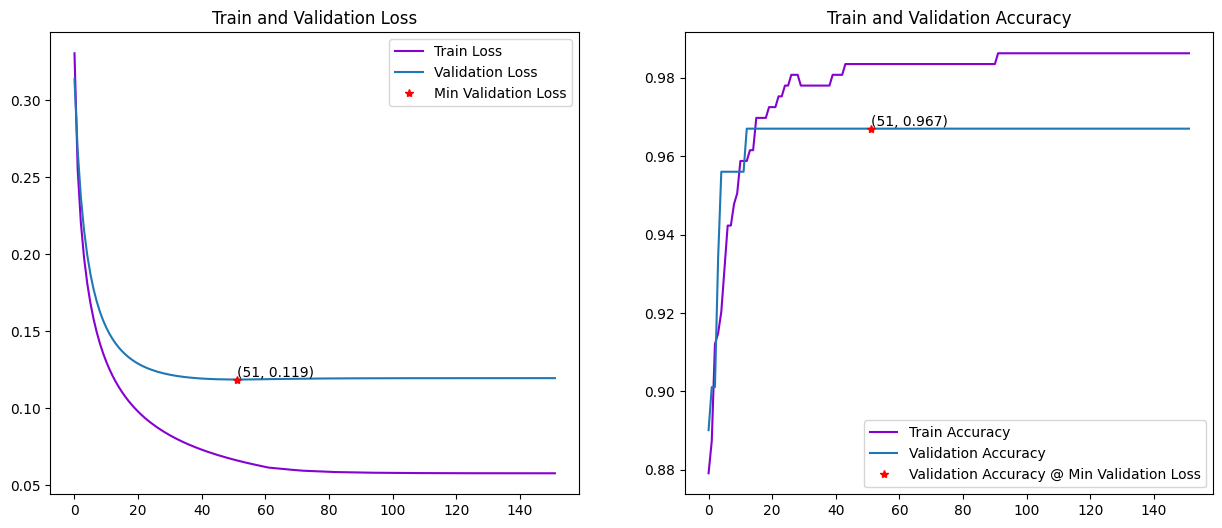

----------------------------------------------------------------------------------------------------
Model Name = MLP_Dropout
Validation Accuracy Mean: 0.031798883341252804, Validation Accuracy STD: 0.02173888259693961
Validation Loss Mean: 0.031798883341252804, Validation Loss STD: 0.02173888259693961
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.997253    0.018553             0.989011         0.026391   
1  1        0.991758    0.035141             0.989011         0.065146   
2  2        0.986264    0.067451             1.000000         0.010856   
3  3        0.989011    0.054644             0.989011         0.040258   
4  4        0.989011    0.052729             1.000000         0.016343   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.970588  
4           1.000000  


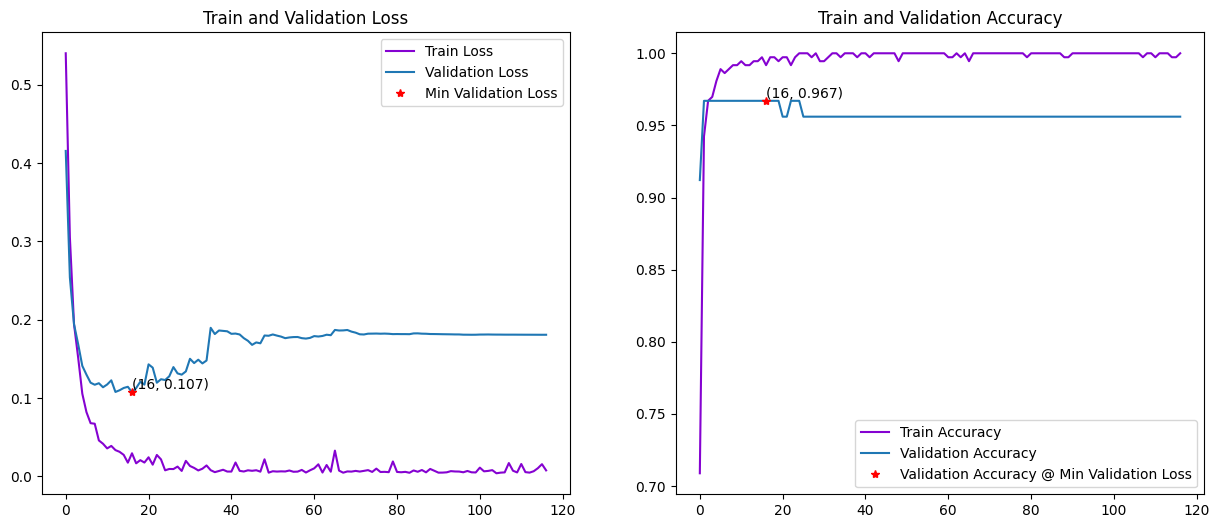

----------------------------------------------------------------------------------------------------
Model Name = MLP_Dropout_Bottleneck
Validation Accuracy Mean: 0.04804287143051624, Validation Accuracy STD: 0.024867259520109496
Validation Loss Mean: 0.04804287143051624, Validation Loss STD: 0.024867259520109496
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.942308    0.113499             0.989011         0.039545   
1  1        0.953297    0.107188             0.978022         0.080628   
2  2        0.942308    0.108435             0.989011         0.017069   
3  3        0.939560    0.132486             0.989011         0.038136   
4  4        0.956044    0.110089             0.978022         0.064836   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.970588  
4           0.970588  


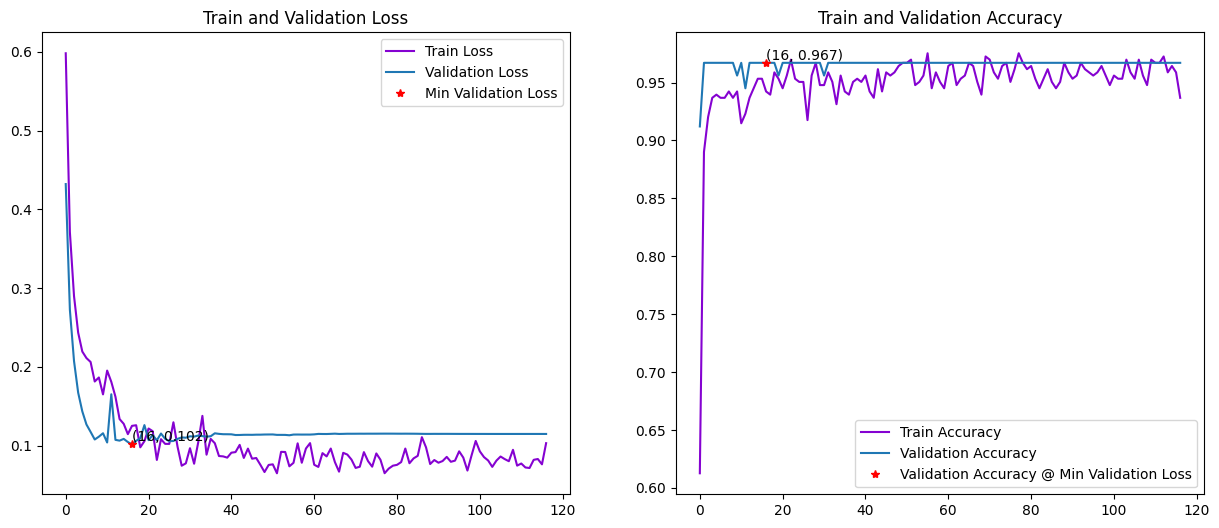

In [103]:
nn_best_models_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

for model_name, model in BEST_MODELS.items():

    print('----------------------------------------------------------------------------------------------------')
    print(f'Model Name = {model_name}')
    
    if model_name == 'SLP':
        history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=32, en_early_stopping=True, en_reduce_lr=True, verbose=0)
        res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, batchSize=32, verbose=0)
    else:
        history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
        res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, batchSize=BEST_BATCH_SIZE, verbose=0)

    proc_data = proc_history(history)

    new_row = {'Model Name': model.name, **proc_data}
    nn_best_models_df.loc[len(nn_best_models_df)] = new_row

    
    print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
    print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
    print(res_df)

    model_history(history)

In [104]:
nn_best_models_df

,Model Name,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,SLP,0.983516,0.066300,0.967033,0.118769,0.944444
1,MLP_Dropout,0.991758,0.029428,0.967033,0.107289,0.944444
2,MLP_Dropout_Bottleneck,0.942308,0.125185,0.967033,0.101663,0.944444


Text(0.5, 1.0, 'Train and Validation Accuracy of Best Models')

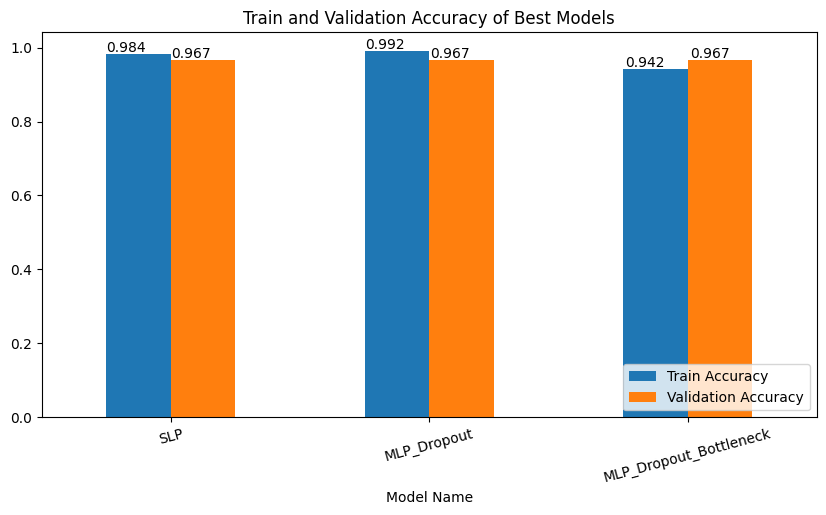

In [105]:
axes = nn_best_models_df.plot.bar(x='Model Name', y=['Train Accuracy', 'Validation Accuracy'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

axes.set_title('Train and Validation Accuracy of Best Models')

Text(0.5, 1.0, 'Train and Validation Loss of Best Models')

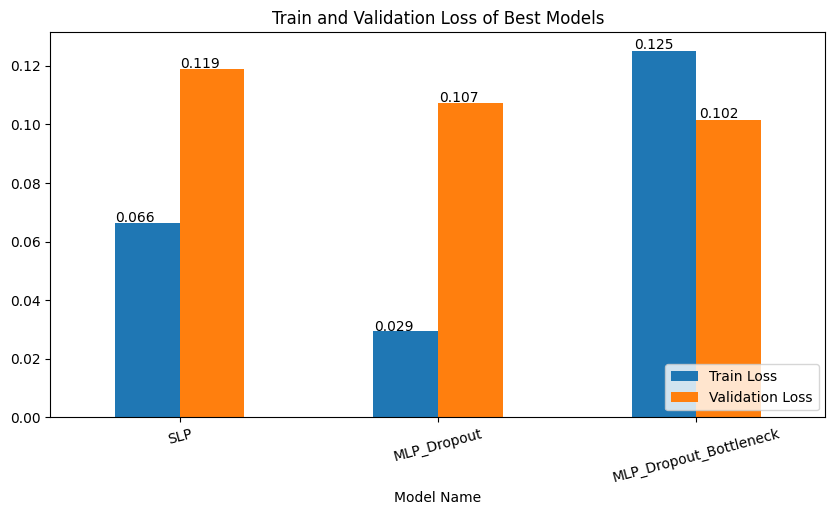

In [91]:
axes = nn_best_models_df.plot.bar(x='Model Name', y=['Train Loss', 'Validation Loss'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

axes.set_title('Train and Validation Loss of Best Models')

### Train+Validation Evaluation

#### Train Evaluation on Best Models

Evaluation Report for Model: SLP on Train
Loss Value: 0.069, Accuracy: 98.352%


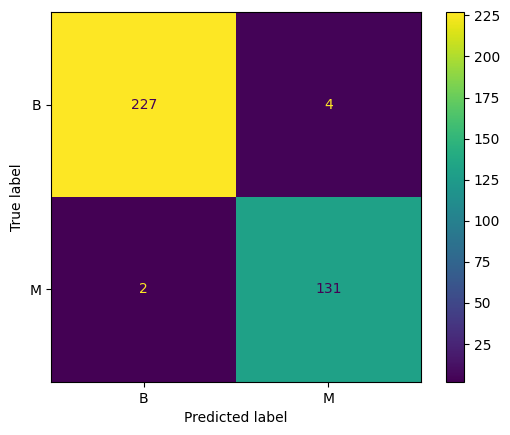

              precision    recall  f1-score   support

           B       0.99      0.98      0.99       231
           M       0.97      0.98      0.98       133

    accuracy                           0.98       364
   macro avg       0.98      0.98      0.98       364
weighted avg       0.98      0.98      0.98       364

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (136.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_Dropout on Train
Loss Value: 0.013, Accuracy: 100.000%


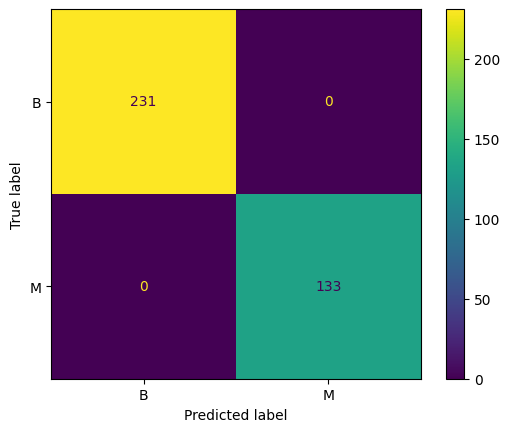

              precision    recall  f1-score   support

           B       1.00      1.00      1.00       231
           M       1.00      1.00      1.00       133

    accuracy                           1.00       364
   macro avg       1.00      1.00      1.00       364
weighted avg       1.00      1.00      1.00       364

Model Summary:


Model: "MLP_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,093 (4.27 KB)

 Trainable params: 1,091 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_Dropout_Bottleneck on Train
Loss Value: 0.034, Accuracy: 99.176%


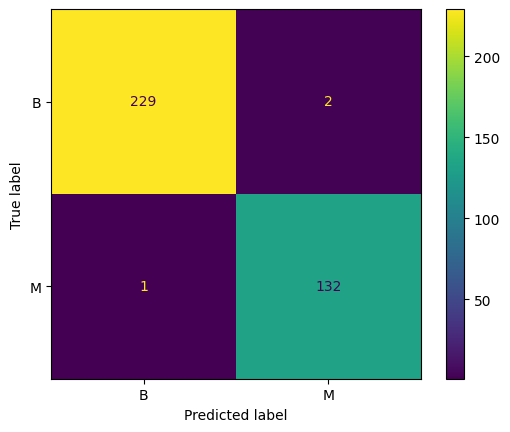

              precision    recall  f1-score   support

           B       1.00      0.99      0.99       231
           M       0.99      0.99      0.99       133

    accuracy                           0.99       364
   macro avg       0.99      0.99      0.99       364
weighted avg       0.99      0.99      0.99       364

Model Summary:


Model: "MLP_Dropout_Bottleneck"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1)              │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254 (1020.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [92]:
for model_name, model in BEST_MODELS.items():
    model_result(model, X_train, y_train, 'Train')

#### Valid Evaluation on Best Models

Evaluation Report for Model: SLP on Valid
Loss Value: 0.119, Accuracy: 96.703%


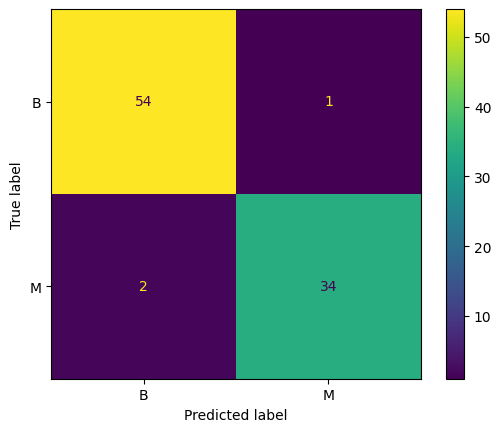

              precision    recall  f1-score   support

           B       0.96      0.98      0.97        55
           M       0.97      0.94      0.96        36

    accuracy                           0.97        91
   macro avg       0.97      0.96      0.97        91
weighted avg       0.97      0.97      0.97        91

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (136.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_Dropout on Valid
Loss Value: 0.107, Accuracy: 96.703%


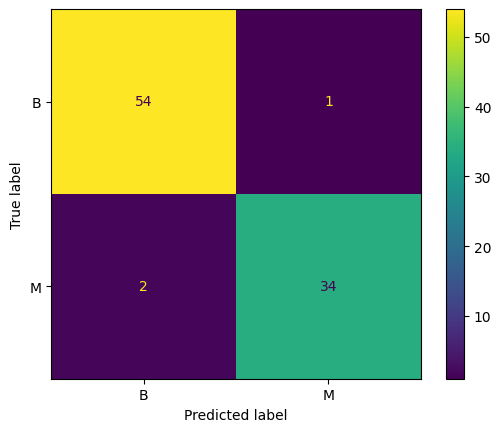

              precision    recall  f1-score   support

           B       0.96      0.98      0.97        55
           M       0.97      0.94      0.96        36

    accuracy                           0.97        91
   macro avg       0.97      0.96      0.97        91
weighted avg       0.97      0.97      0.97        91

Model Summary:


Model: "MLP_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,093 (4.27 KB)

 Trainable params: 1,091 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_Dropout_Bottleneck on Valid
Loss Value: 0.102, Accuracy: 96.703%


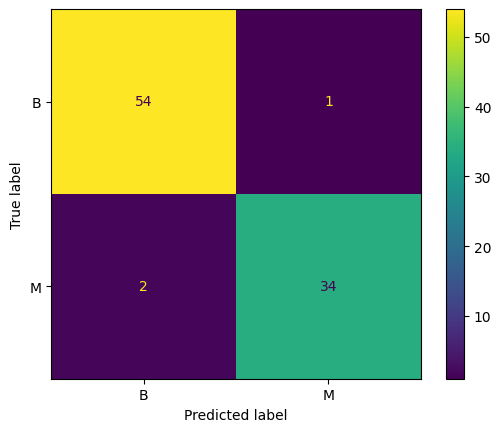

              precision    recall  f1-score   support

           B       0.96      0.98      0.97        55
           M       0.97      0.94      0.96        36

    accuracy                           0.97        91
   macro avg       0.97      0.96      0.97        91
weighted avg       0.97      0.97      0.97        91

Model Summary:


Model: "MLP_Dropout_Bottleneck"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1)              │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254 (1020.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [97]:
for model_name, model in BEST_MODELS.items():
    model_result(model, X_val, y_val, 'Valid')

#### F1_Score, Precision and Recall on Validation of Best Models

In [106]:
from sklearn.metrics import f1_score, precision_score, recall_score

nn_best_models_scores_df = pd.DataFrame(columns=['Model Name', 'Validation F1_Score', 'Validation Precision', 'Validation Recall'])

for model_name, model in BEST_MODELS.items():

    y_prob = model.predict(X_val, verbose=0)
    y_pred = np.round(y_prob).astype(int)    

    f1_score_res = f1_score(y_val, y_pred, labels=le.classes_)
    precision_score_res = precision_score(y_val, y_pred, labels=le.classes_)
    recall_score_res = recall_score(y_val, y_pred, labels=le.classes_)

    new_row = {'Model Name': model.name, 'Validation F1_Score': f1_score_res, 'Validation Precision': precision_score_res, 'Validation Recall': recall_score_res}
    nn_best_models_scores_df.loc[len(nn_best_models_scores_df)] = new_row

In [107]:
nn_best_models_scores_df

,Model Name,Validation F1_Score,Validation Precision,Validation Recall
0,SLP,0.957746,0.971429,0.944444
1,MLP_Dropout,0.957746,0.971429,0.944444
2,MLP_Dropout_Bottleneck,0.957746,0.971429,0.944444


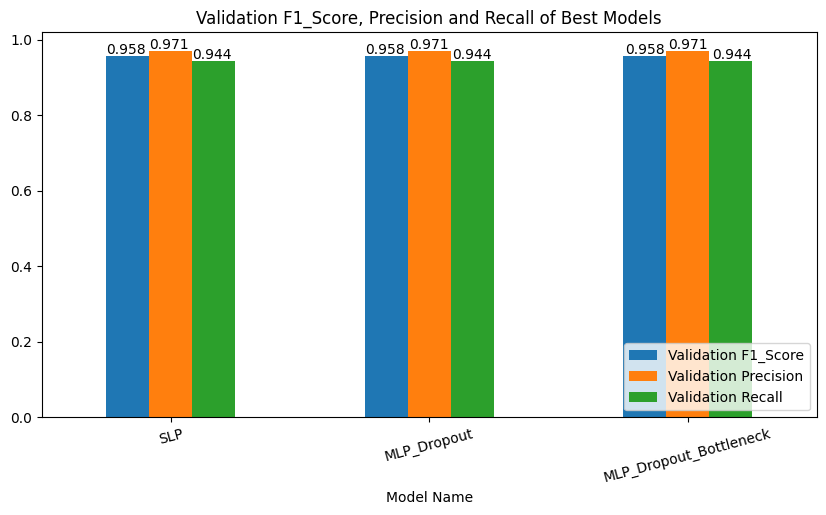

In [108]:
axes = nn_best_models_scores_df.plot.bar(x='Model Name', y=['Validation F1_Score', 'Validation Precision', 'Validation Recall'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Validation F1_Score, Precision and Recall of Best Models')

### Test Evaluation

Evaluation Report for Model: SLP_1 on Test
Loss Value: 0.074, Accuracy: 96.491%


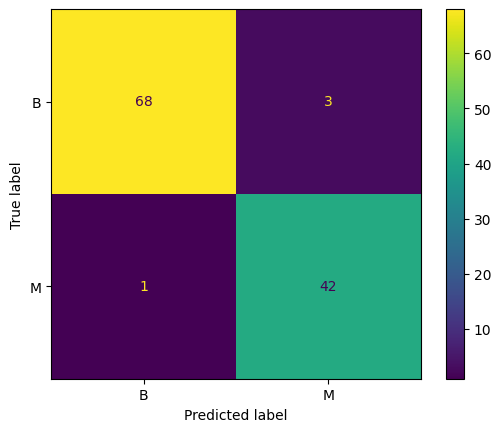

              precision    recall  f1-score   support

           B       0.99      0.96      0.97        71
           M       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Model Summary:


Model: "SLP_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (136.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: NN_30x30x5-D1-x1 on Test
Loss Value: 0.076, Accuracy: 98.246%


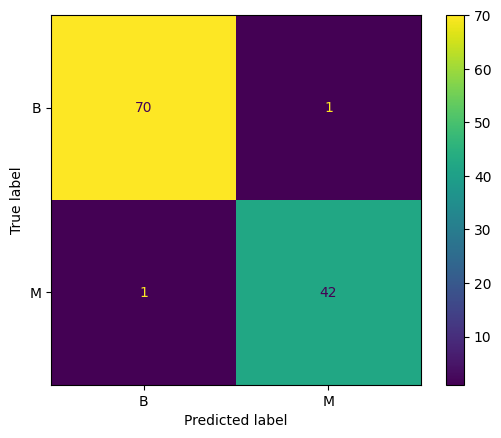

              precision    recall  f1-score   support

           B       0.99      0.99      0.99        71
           M       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Model Summary:


Model: "NN_30x30x5-D1-x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,093 (4.27 KB)

 Trainable params: 1,091 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: NN_30x1x30x5x1 on Test
Loss Value: 0.074, Accuracy: 97.368%


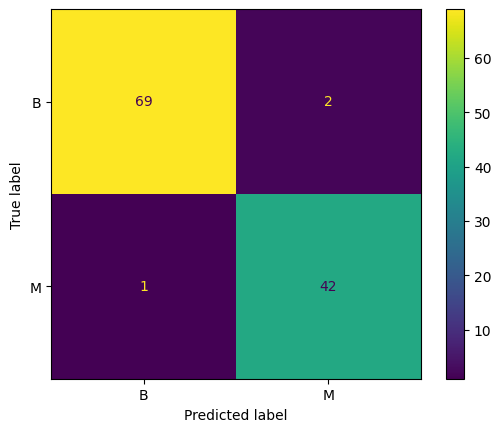

              precision    recall  f1-score   support

           B       0.99      0.97      0.98        71
           M       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Model Summary:


Model: "NN_30x1x30x5x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1)              │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254 (1020.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [21]:
for model_name, model in BEST_MODELS.items():
    model_result(model, X_test, y_test, 'Test')